<a href="https://colab.research.google.com/github/samanthajmichael/dsba6211-summer2024/blob/main/notebooks/dsba6211_summer2024_lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This assignment you are to partially use ChatGPT or LLM's but only for Problems 3 and 6 which are to aid you in interpreting the results. You are not to use ChatGPT or another LLM for Problems 1, 2, 4, 5 and 7. For those, you are to use the [reference material](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html) provided in class.**

# Dependencies

In [55]:
%%capture
!pip install skforecast
!pip install pmdarima

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Data

In [57]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1138&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ENPLANE&scale=left&cosd=2000-01-01&coed=2024-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-27&revision_date=2024-06-27&nd=2000-01-01"

df = pd.read_csv(url, index_col=0, parse_dates=True)
df = df.asfreq('MS')
df.head()

,ENPLANE
DATE,
2000-01-01,46492.0
2000-02-01,48526.0
2000-03-01,58764.0
2000-04-01,56032.0
2000-05-01,58201.0


In [58]:
# filter df only by 2010 to 2020
df = df['2010-01-01':'2019-12-31']

In [59]:
df

,ENPLANE
DATE,
2010-01-01,52552.0
2010-02-01,48682.0
2010-03-01,62219.0
2010-04-01,59659.0
2010-05-01,61468.0
...,...
2019-08-01,83783.0
2019-09-01,72591.0
2019-10-01,78616.0


Train dates : 2010-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=108)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


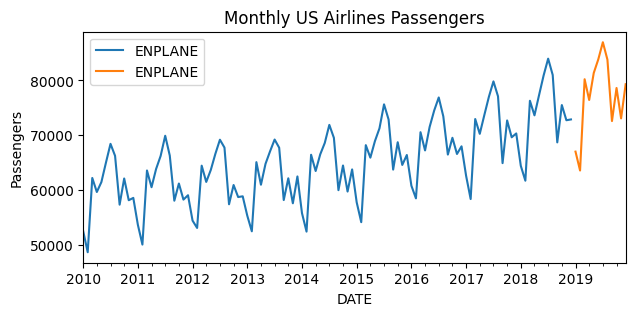

In [60]:
end_train = '2018-12-31 23:59:59'
print(
    f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  "
    f"(n={len(df.loc[:end_train])})"
)
print(
    f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[end_train:])})"
)
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly US Airlines Passengers')
ax.set_ylabel('Passengers')
ax.legend();

Your goal is to develop a time series forecasting model for 2019 using 2010-2018 data as training.

# Problem 1: Visualizing Stationarity (No ChatGPT/LLM)

Use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Stationarity) to plot the train (2010-2018) data and the first/second order differences.

Use the code provided - **do not use ChatGPT** as it may provide alternative libraries code.

**Question**: What order (no difference, 1st order, or 2nd order) should you use to make the time series stationary?

# The second order is non-stationary and is the one I would choose for the time series analysis. Based on the visualization, the second order does not have any discernable patterns.

# Running the statistical tests, the ADF & KPSS agree that the second order is non stationary based on the low p-values.

Remember - you want to select the order that looks like it doesn't have any discernable patterns.

You do not need to run any statistical tests, but you can if you want further evidence.

Test stationarity for original series
-------------------------------------
ADF Statistic: 2.987716290457321, p-value: 1.0
KPSS Statistic: 1.6222459912418603, p-value: 0.01

Test stationarity for differenced series (order=1)
--------------------------------------------------
ADF Statistic: -1.8161531296533324, p-value: 0.3724721137408976
KPSS Statistic: 0.0441419107146943, p-value: 0.1

Test stationarity for differenced series (order=2)
--------------------------------------------------
ADF Statistic: -9.927725198122133, p-value: 2.877116378206007e-17
KPSS Statistic: 0.2693558117282244, p-value: 0.1


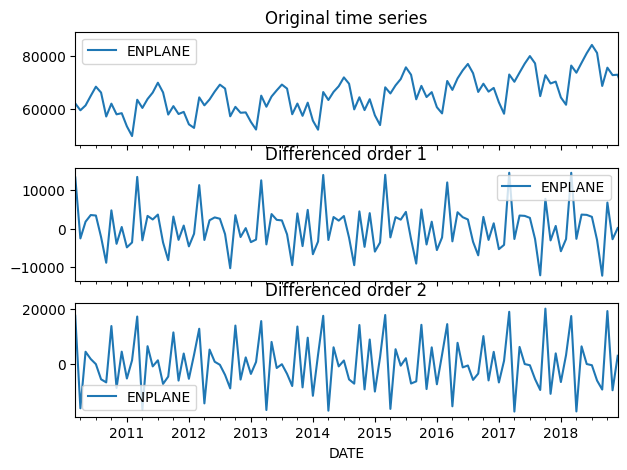

In [61]:
# Test stationarity
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(df)
kpss_result = kpss(df)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_1)
kpss_result = kpss(df.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(data_diff_2)
kpss_result = kpss(df.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
df.plot(ax=axs[0], title='Original time series')
data_diff_1.plot(ax=axs[1], title='Differenced order 1')
data_diff_2.plot(ax=axs[2], title='Differenced order 2');

## Problem 2: ARIMA(1,d,1) (No ChatGPT/LLM)

Set up a ARIMA(1,d,1), where d is the order you selected in Problem 1.

- Use [`skforecast`](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Skforecast) (i.e., `Sarimax`) for ARIMA -- again, don't use ChatGPT as it may use a different library.

- Do not add any seasonal differences at this time (that is, do not provide values to `seasonal_order`)

Fit and run a summary stats on this model.

##ARIMA(1,2,1)

In [62]:
# ARIMA model with skforecast.Sarimax - d=2
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = Sarimax(order=(1, 2, 1))
model.fit(y=data_train)
print(model.summary())
warnings.filterwarnings("default")

                               SARIMAX Results                                
Dep. Variable:                ENPLANE   No. Observations:                  108
Model:               SARIMAX(1, 2, 1)   Log Likelihood               -1080.495
Date:                Tue, 16 Jul 2024   AIC                           2166.989
Time:                        16:00:58   BIC                           2174.979
Sample:                    01-01-2010   HQIC                          2170.228
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0310      0.104     -0.297      0.766      -0.236       0.174
ma.L1         -0.9618      0.044    -22.087      0.000      -1.047      -0.876
sigma2      4.079e+07   9.13e-10   4.47e+16      0.0

In [63]:
# Prediction
# ==============================================================================
predictions_skforecast = model.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']
display(predictions_skforecast.head(4))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,skforecast
2019-01-01,73058.041686
2019-02-01,73231.182295
2019-03-01,73404.350861
2019-04-01,73577.518560


## ARIMA(1,1,1)

In [64]:
# ARIMA model with skforecast.Sarimax - d=1
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train)
print(arima.summary())
warnings.filterwarnings("default")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                               SARIMAX Results                                
Dep. Variable:                ENPLANE   No. Observations:                  108
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1074.680
Date:                Tue, 16 Jul 2024   AIC                           2155.359
Time:                        16:00:59   BIC                           2163.378
Sample:                    01-01-2010   HQIC                          2158.610
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3647      0.216     -1.687      0.092      -0.788       0.059
ma.L1          0.1649      0.234      0.705      0.481      -0.294       0.623
sigma2      2.952e+07   6.23e-09   4.73e+15      0.0

## Problem 3: Interpretation (You may use ChatGPT/LLM)

Now interpret the results of your model from Problem 2.

For this, you **may** use ChatGPT or another LLM but you **must** provide your Share Link of your chat.

Assess your model's results - does it seem like your model fits the data well?

In [65]:
#Interpretation - Chat GPT https://chatgpt.com/share/64d1ed0c-2b92-45da-86a4-7cd48edfb684

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 ## Based on the results of the output summary, it does not look like the ARIMA (1,2,1) time series fits the data well.

 - The log-likelihood is extremely low, when higher values indicate better fit.
 - The AIC, BIC, and HQIC are very high when they should be low.
 - As for the coefficients, the AR (AutoRegressive) is non significant while the MA (Moving Average) is highly significant.

## The ARIMA (1,1,1) model fits the data better and has a:
- Higher log likelihood
- Lower AIC, BIC, aand HQIC
- And as for the coefficients, the MA is highly significant while the AR is now slightly significant.

## Based on these results, I am changing my response to the ARIMA(1,1,1) model with the order 1 being a better choice for d.

## Problem 4: ACF and PACF Plots (No ChatGPT/LLM)

Again, use [this code](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html#Autocorrelation-Analysis) and run ACF and PACF plots on the 0 (no difference), 1st, and 2nd order of your data. **Use the code in the plot** and don't use ChatGPT or else you may get different results.

Given your ACF and PACF plots for the order you choose in Problem 1: do you notice any seasonality patterns?
- Yes it looks like every January, there is a spike or every 12 lags.

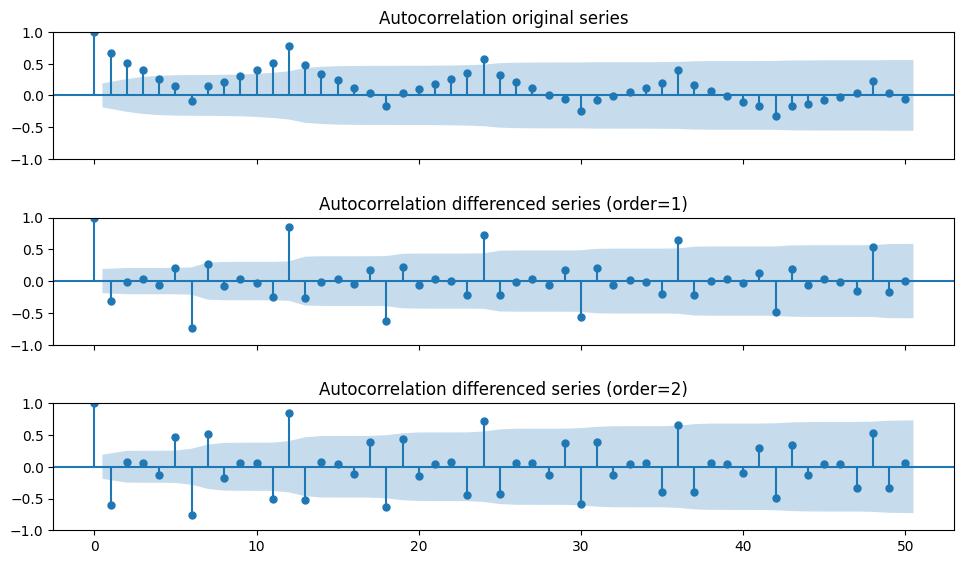

In [66]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
plot_acf(data_train, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)')
plot_acf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Autocorrelation differenced series (order=2)');

fig.tight_layout(pad=2.0)
plt.show()

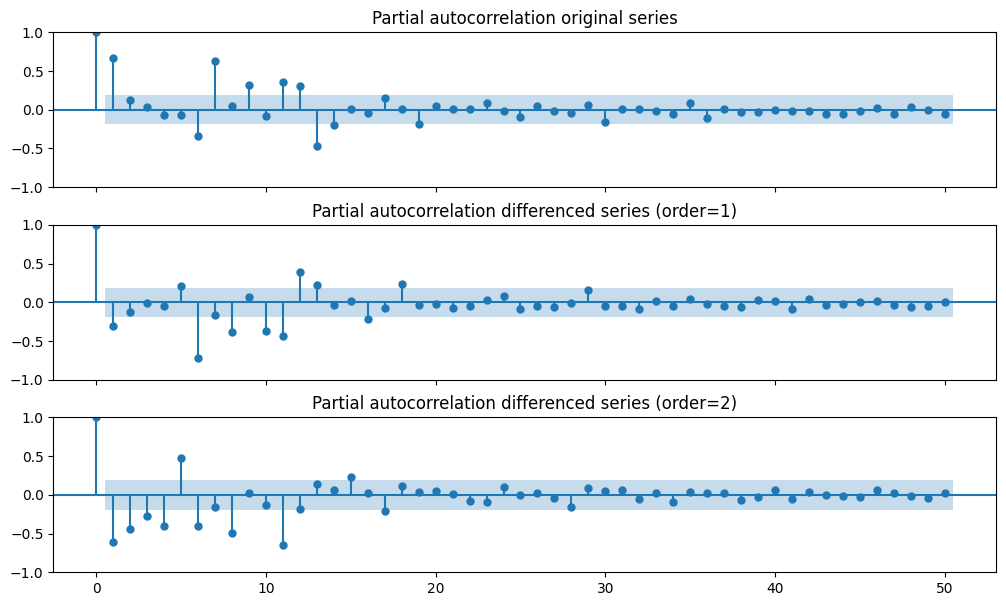

In [67]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 6), sharex=True)
plot_pacf(data_train, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(data_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)')
plot_pacf(data_diff_2, ax=axs[2], lags=50, alpha=0.05)
axs[2].set_title('Partial autocorrelation differenced series (order=2)');

fig.tight_layout(pad=0.5)
plt.show()

## Problem 5: Add in Seasonality Order (No ChatGPT/LLM)

Based on your answer for Problem 3, build a 2nd model and add in a `seasonal_order(1, 1, 1, s)` where `s` is the seasonal periodicity you decided from Problem 3.

In [73]:
# ARIMA model with statsmodels.Sarimax
# ==============================================================================
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog = data_train, order = (1, 1, 1), seasonal_order = (1, 1, 1, 12))
model_res = arima2.fit(disp=0)
warnings.filterwarnings("default")
model_res.summary()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            ENPLANE   No. Observations:                  108
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -818.624
Date:                            Tue, 16 Jul 2024   AIC                           1647.248
Time:                                    16:05:22   BIC                           1660.018
Sample:                                01-01-2010   HQIC                          1652.408
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1074      1.224      0.088      0.930      -2.292       2.507
ma.L1         -0.2003      1.228     -0.163      0.870      -2.608       2.207
ar.S.L12       0.2860      0.367      0.780      0.435      -0.432       1.004
ma.S.L12      -0.3698      0.376     -0.983      0.326      -1.107       0.367
sigma2      1.698e+06   1.67e+05     10.185      0.000    1.37e+06    2.02e+06
===================================================================================
Ljung-Box (L1) (Q):                  23.34   Jarque-Bera (JB):                26.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.58   Skew:                             0.01
Prob(H) (two-sided):                  0.20   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Problem 6: Use ChatGPT to compare and interpret both plots

- Create a prompt to compare the results of both Model 1 and Model 2.

- Provide the ChatGPT shared link.
 - https://chatgpt.com/share/64d1ed0c-2b92-45da-86a4-7cd48edfb684

- Based on the model statistics, which model fits the training data better?
  - The SARIMA model with seasonality fits the training data better as it has a higher log likelihood, and lower AIC, BIC and HQIC statistics.

- What factors should you also consider when making model selection?
 - Other things to consider are the autocorrelation and non normality in the residuals which indicates the model can be further refined.

## Problem 7: Forecasting (No ChatGPT/LLM)

Now use the code below to use your models to forecast for 2019.

The code below assumes your models have the following:
1. Model 1 is named `arima`
2. Model 2 (with seasonality) is named `arima2`

Modify these accordingly to predict your data.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


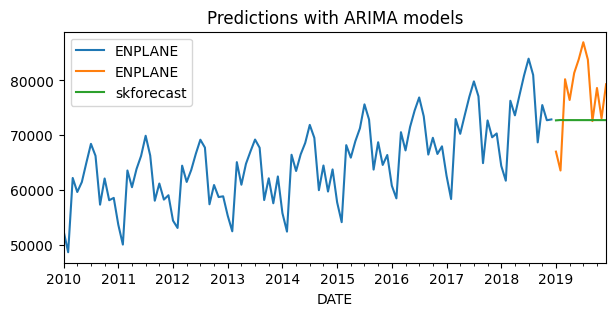

In [69]:
predictions_skforecast = arima.predict(steps=len(data_test))
predictions_skforecast.columns = ['skforecast']

fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

In [74]:
predictions_skforecast2 = model.predict(steps=len(data_test))
predictions_skforecast2.columns = ['skforecast']
fig, ax = plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions_skforecast2.plot(ax=ax, label='skforecast')
ax.set_title('Predictions with ARIMA models')
ax.legend();

TypeError: Model.predict() missing 1 required positional argument: 'params'

Answer these questions, each in 1-2 sentences:

- What is the difference between the two models forecast?

- Visually, which of the two models seem to fit your data out-of-sample (test/2019) data better?

- What are problems you still visualize with your selected model?